In [1]:
import math
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
goal_states = [1, 5]
size_of_maze = 10
episodes = 40

discount = 0.7
alpha = 0.6
e_soft = 0.05

n = 1024
mean = 0
sigma = 1 / math.sqrt(n)

inputs = n
ouputs = 1

reward_bad = -1
reward_good = 0

In [3]:
state_hrrs = np.random.normal(mean, sigma, size=[size_of_maze, n])

identity_hrr = np.zeros(n)
identity_hrr[0] = 1

color_hrrs_internal = np.random.normal(mean, sigma, size=[len(goal_states), n])
color_hrrs_external = np.random.normal(mean, sigma, size=[len(goal_states), n])

In [4]:
def convolve(hrr_1, hrr_2):
    convolved_matrix = np.zeros(n).T
    for j in range(n):
        for k in range(n):
            convolved_matrix[j] += hrr_1[k] * hrr_2[j - k]
    return convolved_matrix.T

In [5]:
def policy(state_left, state_right, wm, color, signal, rand_on):
    # Calculates the value of each possible decision
    # Value of stepping left with signal and with signal and wm
    value_left_state_x = nn.feedforward(convolve(state_hrrs[state_left], signal))
    value_left_state_wm = nn.feedforward(convolve(convolve(state_hrrs[state_left], signal), wm))
    
    # Value of stepping right with signal and with signal and wm
    value_right_state_x = nn.feedforward(convolve(state_hrrs[state_right], signal))
    value_right_state_wm = nn.feedforward(convolve(convolve(state_hrrs[state_right], signal), wm))
    
    # Random move
    if((np.random.random() < e_soft) and (rand_on == 1)):
        return np.random.choice([-1, 1]), wm
    
    # Properly sets signal to the repective internal value
    if(not (np.array_equal(signal, identity_hrr))):
        signal = color_hrrs_internal[color]
    
    # Calculates max value
    max_value = max(value_left_state_x, value_left_state_wm, value_right_state_x, value_right_state_wm)
    
    # Figures out what to return
    if(max_value == value_left_state_x):
        return -1, signal
    elif(max_value == value_left_state_wm):
        return -1, wm
    elif(max_value == value_right_state_x):
        return 1, signal
    elif(max_value == value_right_state_wm):
        return 1, wm

In [6]:
class NeuralNetwork:
    def __init__(self, inputs, outputs, discount, alpha):
        self.discount = discount
        self.alpha = alpha
        self.input = inputs
        self.output = outputs
        self.weights = np.random.randn(outputs, inputs)
        self.bias = 1
        
    def feedforward(self, X):
        self.output = np.dot(self.weights, X) + self.bias
        return self.output
    
    def backprop(self, state_prime_hrr, state_hrr, y):
        if(y == reward_good):
            self.error = (reward_bad + self.discount * self.feedforward(state_hrr)) - self.feedforward(state_prime_hrr)
            self.weights = np.add(self.weights, (self.alpha * self.error * state_prime_hrr))
            self.error = reward_good - self.feedforward(state_hrr)
            self.weights = np.add(self.weights, (self.alpha * self.error * state_hrr))
        else:
            self.error = (reward_bad + self.discount * self.feedforward(state_hrr)) - self.feedforward(state_prime_hrr)
            self.weights = np.add(self.weights, (self.alpha * self.error * state_prime_hrr))

In [7]:
nn = NeuralNetwork(n, 1, discount, alpha)

In [10]:
state = random.randint(0, size_of_maze - 1)
state_prime = state

rand_color = np.random.choice(len(goal_states))
goal_state = goal_states[rand_color]
signal = color_hrrs_external[rand_color]
old_signal = signal
old_wm = wm
wm = identity_hrr

for x in range(episodes):
        while(state != goal_state):
            old_wm = wm
            color = rand_color
            print("Goal:", goal_state, "In state: ", state)
            if(state == 0):
                decision, wm = policy(size_of_maze - 1, 1, wm, color, signal, 1)
                if(decision == -1):
                    state_prime = state
                    state = size_of_maze - 1
                else:
                    state_prime = state
                    state = state + decision
            elif(state == size_of_maze - 1):
                decision, wm = policy(state - 1, 0, wm, color, signal, 1)
                if(decision == -1):
                    state_prime = state
                    state = state + decision
                else:
                    state_prime = state
                    state = 0
            else:
                decision, wm = policy(state - 1, state + 1, wm, color, signal, 1)
                state_prime = state
                state = state + decision
            print(wm)
            nn.backprop(convolve(convolve(state_hrrs[state_prime], old_wm), old_signal), convolve(convolve(state_hrrs[state], wm), signal), reward_bad)
            old_signal = signal
            signal = identity_hrr
        nn.backprop(convolve(convolve(state_hrrs[state_prime], old_wm), old_signal), convolve(convolve(state_hrrs[state], wm), signal), reward_good)
        state = random.randint(0, size_of_maze - 1)
        state_prime = state
        rand_color = np.random.choice(len(goal_states))
        goal_state = goal_states[rand_color]
        signal = color_hrrs_external[rand_color]
        wm = identity_hrr
        print("Episode", x+1, "done")

Goal: 1 In state:  5
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  6
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  7
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  8
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  9
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  8
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  9
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  0
[1. 0. 0. ... 0. 0. 0.]
Episode 1 done
Goal: 5 In state:  6
[-0.01313209 -0.00476247  0.02064105 ... -0.00496869  0.05506697
  0.06791258]
Episode 2 done
Goal: 5 In state:  4
[-0.01313209 -0.00476247  0.02064105 ... -0.00496869  0.05506697
  0.06791258]
Episode 3 done
Goal: 1 In state:  9
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  0
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Episode 4 done
Goal: 1 In stat

Goal: 1 In state:  0
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Episode 17 done
Goal: 1 In state:  5
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  4
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  5
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  4
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  5
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  6
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  5
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  4
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  3
[1. 0. 0. ... 0. 0. 0.]
Goal: 1 In state:  2
[1. 0. 0. ... 0. 0. 0.]
Episode 18 done
Episode 19 done
Goal: 1 In state:  3
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871789
  0.01199126]
Goal: 1 In state:  2
[ 0.07975976 -0.0094377   0.04682806 ...  0.00426689 -0.04871

Episode 36 done
Goal: 5 In state:  1
[-0.01313209 -0.00476247  0.02064105 ... -0.00496869  0.05506697
  0.06791258]
Goal: 5 In state:  2
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  1
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  2
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  1
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  2
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  1
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  0
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  9
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  8
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  9
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  0
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  1
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  2
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  3
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  4
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  3
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  4
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  3
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  2
[1. 0. 0. ... 0. 0. 0.]
Goal: 5 In state:  1
[1. 0. 0

In [11]:
possible_signals = np.vstack((identity_hrr, color_hrrs_external))
possible_wm = np.vstack((identity_hrr, color_hrrs_internal))

-0.9906514416565622
0.0015219820626726221
-0.006921002224649753
1.990601473561301
2.304937871081208
4.436268936922776
1.6529803007608013
2.216572667777675
3.039425469814524


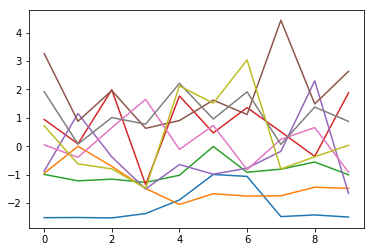

In [12]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for x in range (np.size(possible_signals, 0)):
    for y in range (np.size(possible_wm, 0)):
        for z in range (size_of_maze):
            value[z] = nn.feedforward(convolve(state_hrrs[z], (convolve(possible_signals[x], possible_wm[y]))))
        plt.plot(position, value) 
        print(np.amax(value))

-0.006921002224649753


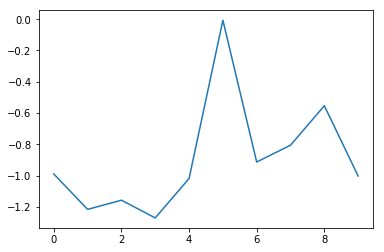

In [13]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for z in range (size_of_maze):
    value[z] = nn.feedforward(convolve(state_hrrs[z], possible_wm[2]))
plt.plot(position, value) 
print(np.amax(value))